 ‫‪5‬‬‫‪-‬‬‫برای‬‫تصاویر‬ ‫حاصل‬ ‫از‬ ‫قسمت‬ ‫قبل‪،‬‬ ‫‪5‬‬ ‫ویژگی‬ ‫قابل‬ ‫توجه‬ ‫به‬ ‫طور‬ ‫دلخواه‬ ‫استخراج‬ ‫کنید‪.‬‬

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Load the image

files = [
    'assignment/Medium/panguan.jpg', 
    'assignment/Medium/star.jpg', 
    'assignment/Medium/horse.jpg', 
    'assignment/Medium/man.jpg', 
    'assignment/Medium/spider.jpg', 

    'assignment/Hard/boat.jpg', 
    'assignment/Hard/goat.jpg', 
    'assignment/Hard/paris.jpg', 
    'assignment/Hard/snake.jpg', 
    'assignment/Hard/taj.jpg', 
    
    'assignment/Easy/car.jpg', 
    'assignment/Easy/horse.jpg', 
    'assignment/Easy/church.jpg', 
    'assignment/Easy/pyrmid.jpg', 
    'assignment/Easy/flower.jpg'
]

images = []
for file in files:
    image = cv2.imread(file)
    images.append(image)

In [4]:
rgb_images = []

for image in images:
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_images.append(rgb)

### Method #1: Grayscale Pixel Values as Features

In [6]:
gray_images = []
for file in files:
    gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    gray_images.append(gray)
    
# gray.shape # (321, 481)

In [5]:
features_of_images = []

for image in gray_images:
    features = np.reshape(image, (image.shape[0] * image.shape[1]))
    features_of_images.append(features)
    print(features)

[144 145 146 ...  48  50  55]
[ 31  30  29 ... 114 112  35]
[ 12  12  12 ... 143 145 153]
[ 59  58 140 ... 238 213 144]
[42 52 53 ... 80 84 88]


### Method #2: Mean Pixel Value of Channels

In [7]:
# create a matrix of mean of all 3 channel of colored image
mean_matrix_images = []

for image in images:
    
    mean_matrix = np.zeros(image.shape[:2])
    
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            mean_matrix[row][col] = (int(image[row, col, 0]) + int(image[row, col, 1]) + int(image[row, col, 2])) / 3
            

    mean_matrix_images.append(mean_matrix)
    # print(mean_matrix.shape) # (321, 481)

print(mean_matrix)

[[ 11.          11.          11.         ...  80.33333333  70.
   58.33333333]
 [ 11.          11.          11.         ...  77.33333333  68.
   60.33333333]
 [ 11.          11.          11.         ...  79.33333333  71.
   60.33333333]
 ...
 [  8.66666667   8.66666667  10.         ... 141.33333333 149.33333333
  151.33333333]
 [  9.66666667  10.           9.33333333 ... 137.33333333 145.33333333
  148.33333333]
 [ 10.66666667   9.33333333  10.         ... 135.         137.
  144.33333333]]


### Method #3: Extracting Edge Features

In [31]:
canny_edges = []

for image in gray_images:

    # Noise removing
    img_gaussian = cv2.GaussianBlur(image,(3,3),0)

    # CANNY METHOD
    canny = cv2.Canny(img_gaussian, 100, 200)
    canny_edges.append(canny)

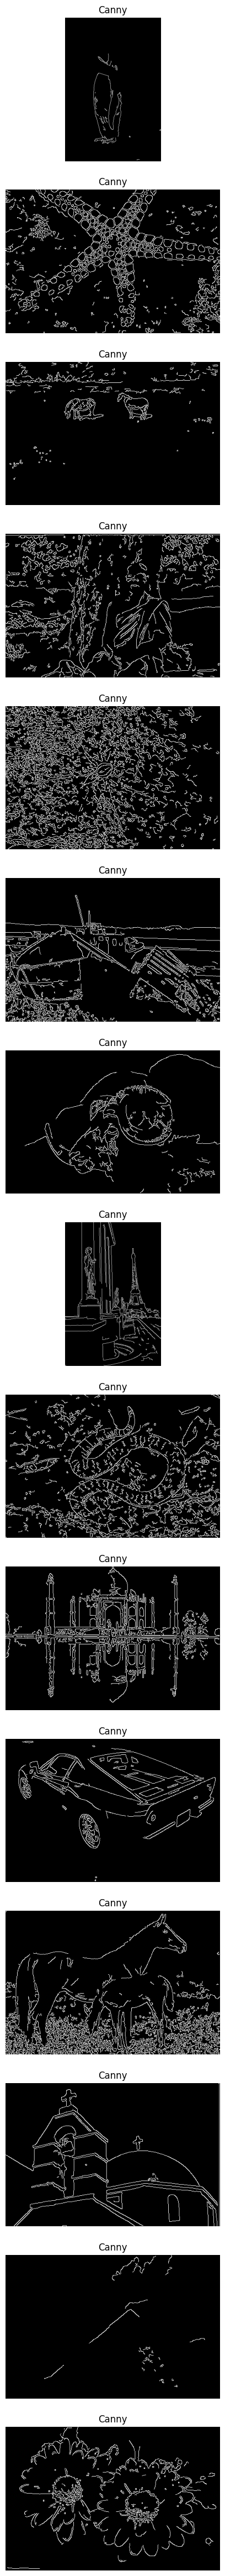

In [32]:
figure, axis = plt.subplots(nrows=len(images), ncols=1, figsize=(12, 4*len(images)))

for i in range(len(images)):

    axis[i].set_title('Canny')
    axis[i].imshow(canny_edges[i], cmap='gray')
    axis[i].axis('off')

### Method #4: Histogram

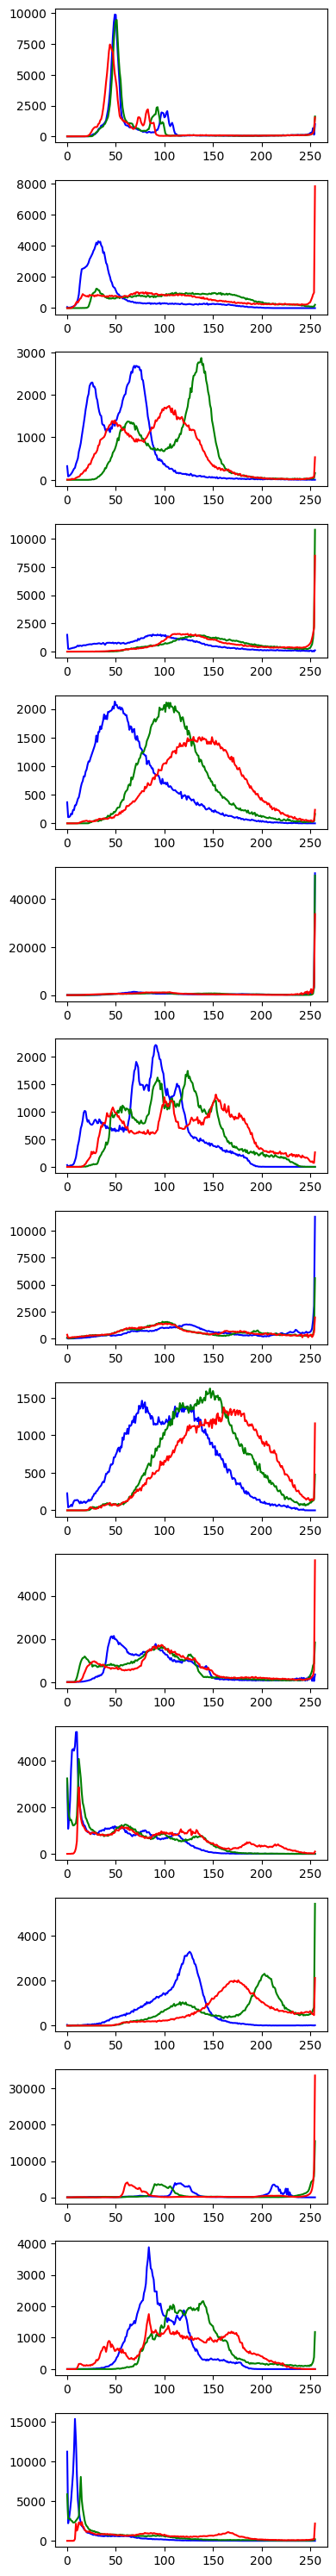

In [10]:
hists = []
colors = ('b', 'g', 'r')

figure, axis = plt.subplots(nrows=len(images), ncols=1, figsize=(4, 30))


for ii, image in enumerate(images):
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], channels=[i], mask=None, histSize=[256], ranges=[0, 256])
        axis[ii].plot(hist, color=color)



figure.tight_layout()

### Method 5: Chain Code

In [13]:
def draw(image, title = "Original Grayscale Image"):
    # Display original grayscale image
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [27]:
# Apply simple thresholding
binary_images = []

for gray_image in gray_images:
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
    binary_images.append(binary_image)
    

In [18]:
# Step 1: Convert the grayscale image to binary using Canny edge detection
edges = cv2.Canny(gray_image, 100, 200)

# Step 2: Apply morphological operations to close gaps and make edges thicker
kernel = np.ones((3, 3), np.uint8)
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
dilated_edges = cv2.dilate(closed_edges, kernel, iterations=1)


In [23]:
def get_chain_code(binary_image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming we are interested in the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Initialize the chain code
    chain_code = []
    
    # Define the 8 possible directions (clockwise)
    directions = [
        (0, 1),  # Right
        (1, 1),  # Down-Right
        (1, 0),  # Down
        (1, -1), # Down-Left
        (0, -1), # Left
        (-1, -1),# Up-Left
        (-1, 0), # Up
        (-1, 1)  # Up-Right
    ]

    # Starting point (first point of the contour)
    start_point = tuple(largest_contour[0][0])
    current_point = start_point

    # Loop through the contour points to generate the chain code
    for point in largest_contour[:, 0, :]:
        dx = point[0] - current_point[0]
        dy = point[1] - current_point[1]

        # Find the direction of movement
        for i, (dx_dir, dy_dir) in enumerate(directions):
            if (dx_dir == dx) and (dy_dir == dy):
                chain_code.append(i)
                break

        current_point = tuple(point)

    return chain_code



In [29]:
# Get the chain code

chain_codes = []

for binary_image in binary_images:
    chain_code = get_chain_code(binary_image)
    chain_codes.append(chain_code)
    print("Chain Code:", chain_code)


Chain Code: [7, 0, 0, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 1, 1, 7, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 7, 3, 1, 7, 1, 7, 1, 1, 7, 1, 0, 1, 0, 5, 4, 5, 5, 3, 1, 0, 1, 0, 4, 5, 3, 1, 1, 1, 2, 4, 1, 4, 3, 4, 3, 1, 0, 1, 7, 2, 4, 3, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 7, 6, 7, 0, 7, 0, 7, 5, 5, 1, 0, 1, 4, 3, 1, 6, 2, 7, 1, 0, 7, 3, 0, 1, 1, 0, 1, 7, 3, 1, 0, 1, 0, 3, 5, 3, 4, 3, 1, 4, 3, 1, 0, 2, 4, 6, 5, 3, 1, 3, 1, 5, 3, 0, 4, 3, 1, 7, 2, 3, 1, 0, 3, 1, 2, 1, 7, 5, 6, 7, 5, 3, 2, 6, 5, 6, 5, 6, 5, 3, 4, 5, 4, 5, 4, 3, 2, 1, 5, 5, 4, 3, 2, 4, 6, 7, 5, 3, 2, 4, 3, 5, 1, 0, 7, 5, 3, 5, 4, 4, 3, 1, 4, 5, 4, 3, 1, 5, 3, 7, 2, 1, 0, 7, 1, 0, 4, 3, 1, 1, 2, 4, 5, 4, 5, 5, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 7, 5, 3, 5, 3, 4, 6, 5, 5, 3, 5, 5, 5, 5, 5, 5, 3, 4, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5]
Chain Code: [0, 0, 7, 6, 5, 4, 3, 2, 1, 1, 2, 1, 7, 1, 0, 1, 7, 2, 1, 2, 1, 2, 1, 3, 3, 3, 3, 4, 2, 3, 5, 7, 6, 5, 1, 2, 6, 5, 3, 2, 3, 2, 1, 0, 2, 1, 7, 6, 7, 0, 7, 7, 5, 0, 1, 7, 7, 0,